In [28]:
from sklearn.linear_model import LinearRegression

from glm_utils.preprocessing import time_delay_embedding, BasisProjection
import glm_utils.bases

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ncb.mplstyle')


We define a toy model with a pre-defined filter to generate responses `y` from a dummy stimulus `x`. Then, we'll use linear regression to recover the filter from `x` and `y`.

The filter below means that the response at time t, `y(t)`, is high/low when the stimulus is high/low 3 and 2 time steps in the past of the response - in other words, stimulus and response positively correlated for these delays. At -5, the filter value is negative - for this delay, stimulus and response are negatively correlated.

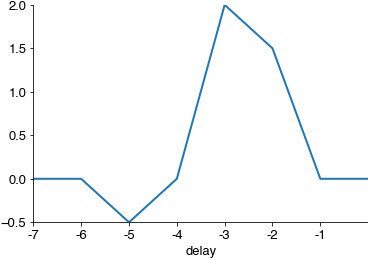

In [117]:
x = np.random.random((2000, 1))  # the dummy stimulus

filter = np.array([0, 0, -0.5, 0, 2, 1.5, 0, 0])  # the pre-defined filter

window_size = len(filter)
plt.plot(filter, linewidth=2)
plt.xticks(np.arange(window_size), -np.arange(window_size-1,0,-1))
plt.xlabel('delay');

This is done via _time delay embedding_: Standard GLMs use the current stimulus value `x(t)` to predict `y(t)`: $y(t) = w * x(t)$.

To recover the history dependence of the response, we need to make time explicit in the inputs to our GLM. We use values at different delays preceeding $t$ : 
$$\vec x(t) = [x(t), x(t-1), ..., x(t-d\tau),..., x(t-\tau_{max})]$$, 
where $\tau$ is the maximal delay value. The model is then 
$$y(t) = \sum_\tau^{\tau_{max}} w(\tau) * x(t-\tau) = \vec w^T\vec x(t) $$. 

The estimated filter is then given by $\vec w = [w_0, ..., w_{{\tau}_{max}}]$

The result of this time delay embedding is illustrated below. Each column in the matrix is one input stimulus $\vec x$ to the GLM, where the entries for larger delays are just time shifted versions of the original stimulus. All vectors are collected in one large design matrix $X$:

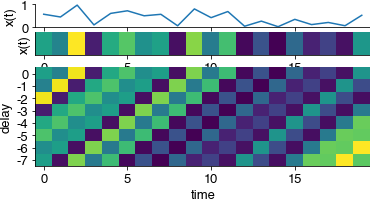

In [118]:
X = time_delay_embedding(x, window_size=window_size)

plt.subplot(8,1,3)
plt.plot(x[:20])
plt.xlim(-0.5, 19.5)
plt.ylabel('x(t)')

plt.subplot(8,1,4)
plt.imshow(x[:20].T)
plt.yticks([]);
plt.ylabel('x(t)')

plt.subplot(212)
plt.imshow(X[:20,:].T)
plt.xlabel('time')
plt.ylabel('delay')
plt.yticks(np.arange(window_size), -np.arange(window_size));

In [119]:
# generate the dummy response data
y = np.dot(X, filter)

We can now use sklearn to fit the model (we use linear regression for simplicity; a GLM will yield the same results for this example). `lm.coef_` are the filter estimated weights.

Text(0, 0.5, 'w(tau)')

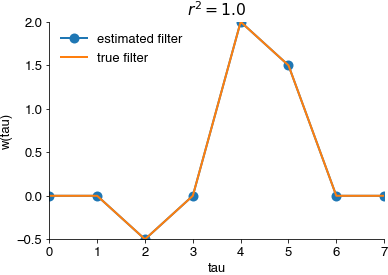

In [120]:
# make sure this works as is
lm = LinearRegression()
lm.fit(X, y)
plt.plot(lm.coef_, 'o-', linewidth=2, markersize=10, label='estimated filter')
plt.plot(filter, linewidth=2, label='true filter')
plt.legend();
plt.title(f'$r^2={lm.score(X, y):1.2}$');
plt.xlabel('tau')
plt.ylabel('w(tau)')

Our data typically has much higher resolution than the behavior. For instance we quantify the female speed every 10ms, 
but the male presumably does not update his behavior with the same speed and temporal resolution. 
Combined with the need to consider female speed for quite some time in the past, 
we end up with many delays and huge design matrices.

That's where using _basis functions_ comes into play. Instead of estimating each time point of the filter directly and independently - as is done when we estimate the filter from the raw design matrix $X$ - we estimate the filter as a weighted sum of bases functions that typically span multiple time points. That way we can estimate fewer parameters (number of basis functions < number of time points), making the fitting faster and more robust for small data sets. In addition, careful choice of the basis functions allows us to incorporate more prior information. For instance:
- filters are typically smooth: use broad and smooth basis functions
-fast filter components occur at small delays and the filter becomes broader for larger delays: increase the width of the basis function with the delay

`glm_utils` has a couple of basis functions (see [wiki](https://github.com/janclemenslab/glm_utils/wiki/Basis-functions)). 

For this example we choose "raised cosine bumps" that get broader with delay: 

Text(0.5, 0, 'delay tau')

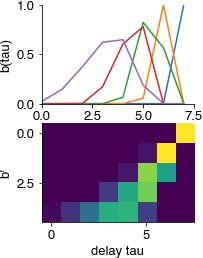

In [121]:
B = glm_utils.bases.raised_cosine(1, 4, [0, 2.4], 1)  # the basis functions
plt.subplot(221)
plt.plot(B)
plt.xlabel('delay')
plt.ylabel('b(tau)')

plt.subplot(223)
plt.imshow(B.T)

plt.ylabel('b\'')
plt.xlabel('delay tau')


To estimate the filter using basis functions, each delay embedded stimulus $\vec x(t)$ is projected onto all basis functions.
While the original design matrix $X$ was [T x $\tau_{max}]$ (T=number of time points), the new design matrix $X_b$ is now [T x num basis functions].

The regression coefficients `lm.coef_` now correspond to a weight w'(b') for each basis function $b(\tau)$.

/Users/janc/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


Text(0, 0.5, "w'(b')")

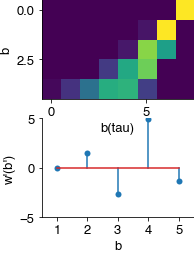

In [114]:
# init the Projection objects which can project stimuli onto the basis functions and
# also recover the time-domain filter from the basis coefficients
basis_projection = BasisProjection(B)  

X_b = basis_projection.transform(X)

lm = LinearRegression()
lm.fit(X_b, y)

basis_weights = lm.coef_
B = glm_utils.bases.raised_cosine(1, 4, [0, 2.4], 1)  # the basis functions
plt.subplot(221)
plt.imshow(B.T)
plt.ylabel('b')
plt.xlabel('b(tau)')

plt.subplot(223)
plt.stem(basis_weights)
plt.xlim(-0.5, 4.5)
plt.xticks(np.arange(5), np.arange(1,6))
plt.xlabel('b')
plt.ylabel('w\'(b\')')


The time-domain filter can be recovered by multiplying each basis function $b(\tau)$ with 
its weight w'(b') and summing them all up: $w(\tau) = \sum_{b'} w'(b') * \vec b(\tau)$. This is what `basis_projection.inverse_transform` does.

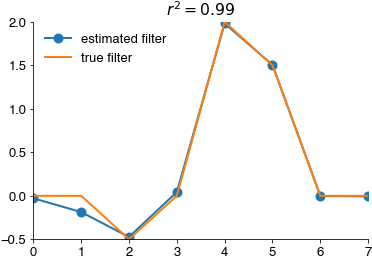

In [116]:
estimated_filter = basis_projection.inverse_transform(basis_weights[:,np.newaxis].T)

plt.plot(estimated_filter.T, 'o-', linewidth=2, markersize=10, label='estimated filter')
plt.plot(filter, linewidth=2, label='true filter')
plt.legend()
plt.title(f'$r^2={lm.score(X_b, y):1.2}$');